In [2]:
import numpy as np
import feature_extraction.simple_extractor_py3 as extractor
import pretreatment.pretreatment as preatreatment
import tools.drawer_utils as drawer_utils
import tools.sound_utils as sound_utils
from scipy.io import wavfile
from imp import reload
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
wave_file = r"./datas/A2_0.wav"

In [4]:
sampling_freq , audio = wavfile.read(wave_file) # 读出采样率和时域数据矩阵
sound_utils.play_sound(audio,sampling_freq)

In [5]:
print(sampling_freq,audio)

16000 [-296 -424 -392 ... -394 -379 -390]


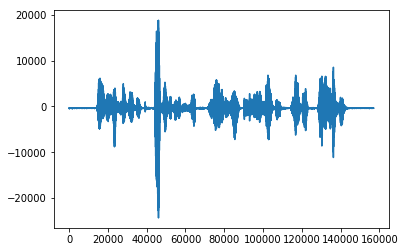

In [6]:
drawer_utils.plot_array(audio)

### 预加重  pre-emphasis

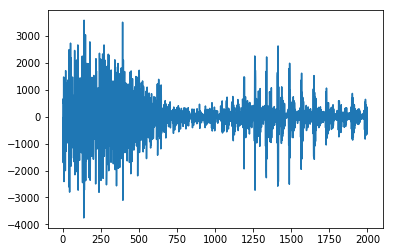

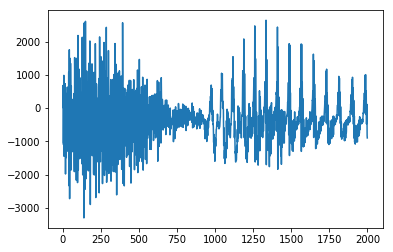

In [7]:
pre_emphasised = preatreatment.pre_emphasis(audio,0.98)
drawer_utils.plot_array(pre_emphasised[20000:22000])
drawer_utils.plot_array(audio[20000:22000])

In [8]:
sound_utils.play_sound(pre_emphasised,sampling_freq)
# from IPython.display import Audio
# Audio(data=pre_emphasised, rate=sampling_freq)

#### 作用
* 增强高频能量，提升高频分辨率，衰弱200HZ以下的频率成分

#### 问题
* 预加重后，反而噪音变强了

#### 发现
* 预加重后，时域波形图明显变“密”了（高音部分变多了，所以直观地听起来就是更嘈杂了）
* 频率越高声音越尖，频率越低声音越低沉
* 明显听后者声音更加低沉

#### 个人理解
* 虽然噪声变大了，但是发现预处理后，整个音频都充斥着这个噪声，在计算机看来，这个噪声其实可以理解成“没有噪声”（只是相对的）

### 分帧、加窗

In [9]:
# 无加窗
frames = preatreatment.enframe(pre_emphasised,512,256)
# 加hanning窗
import scipy.signal as signal
hanning_frames = preatreatment.enframe(pre_emphasised,512,256,signal.hanning(512))

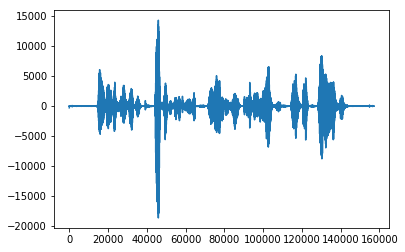

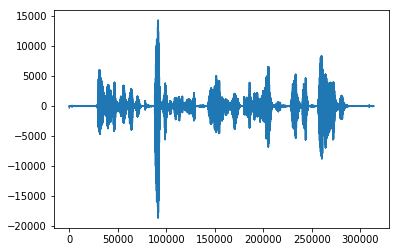

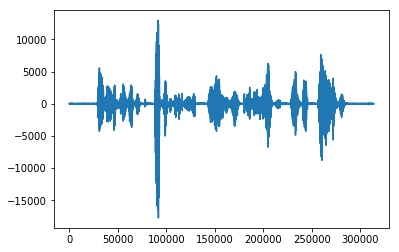

In [10]:
drawer_utils.plot_array(pre_emphasised)
drawer_utils.plot_array(frames.flatten())
drawer_utils.plot_array(hanning_frames.flatten())

#### 作用
* 语音信号本是一种典型的非平稳信号，但是相对于声波振动的速度，发音器官的运动就是非常缓慢的了，所以工程上通常认为10-30ms这样长度的时间段中，语音信号是平稳的

#### 问题
* 无

#### 发现
* 整体音频变长了，说话变缓了,毕竟有叠音。
* 未加窗的有明显的拖长和重声的现象
* 加了hanning窗后，重声现象有效减缓

#### 个人理解
* 整体作用如上所述，这样变换后，让音频更像“图像”了。但是比图像的像素更具连续性的特点
* hanning窗，保留中间部分，消弱边缘部分，能够有效抑制重音现象

### 短时能量

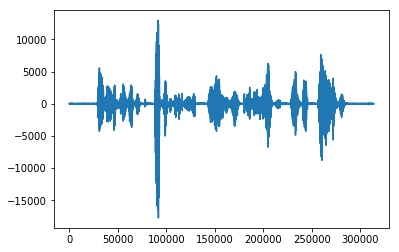

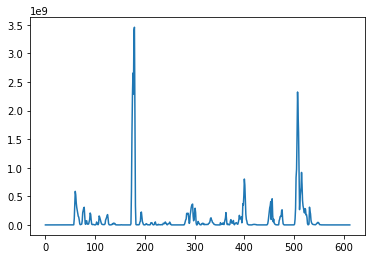

In [11]:
drawer_utils.plot_array(hanning_frames.flatten())
drawer_utils.plot_array(extractor.cal_energy(hanning_frames))

#### 作用
* 代表语音帧的能量大小，可以用来检测端点

#### 问题
* 无

#### 发现
* 能够看出能量的聚集点，明显“大”字（180帧左右）这块能量最高

#### 个人理解
* 能够反应轻重音和快慢音的特征。

### 短时平均幅度

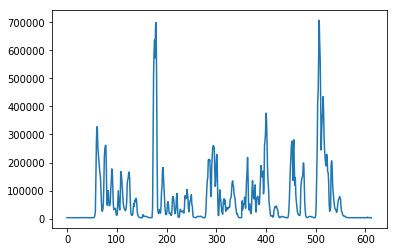

In [12]:
drawer_utils.plot_array(extractor.cal_amplitude(hanning_frames))

#### 作用
* 代表语音帧的能量大小，可以用来检测端点等

#### 问题
* 无

#### 发现
* 明显幅度差变低，更“像”原音频

#### 个人理解
* 对于高音不那么敏感。

### 短时过零率

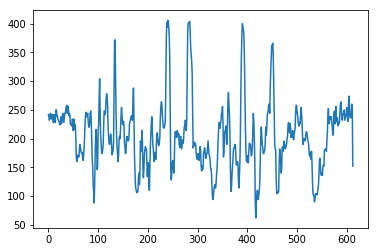

In [13]:
drawer_utils.plot_array(extractor.cal_crossing_zero_rate(hanning_frames))

#### 作用
* 过零率越大证明该帧频率越大,清音段多数在高频率上，平均过零率大，而浊音较小

#### 问题
* 无

#### 发现
* 较乱，暂无发现

#### 个人理解
* 无

### 短时自相关函数

In [14]:
# 获取自相关函数值
# self_corr = extractor.self_correlation(hanning_frames)
# print(np.shape(self_corr))
# 获取f0
# f0 = extractor.get_f0_by_corr(self_corr)
# drawer_utils.plot_array(f0)

#### 作用
* 能够计算出基频，能够用于区分清浊音
* 自相关系数在基频倍频处呈现突出的函数幅度值

#### 问题
* 计算基音周期时，不一定选择第一个峰值位置。

#### 发现
* 基音周期相对较高的帧确实对应着“有台词”的地方（测试音频基本都为浊音）

#### 个人理解
* 基音周期有高有低，表明原始音频中的浮渣性

### 短时平均幅度差函数

In [15]:
# 获取短时平均幅度差函数值
# ave_amplitude = extractor.average_amplitude(hanning_frames)
# 获取f0
# f0 = extractor.get_f0_amplitude(ave_amplitude)
# drawer_utils.plot_sound(f0)

#### 作用
* 能够计算出基频，能够用于区分清浊音
* 自相关系数在基频倍频处呈现突出的函数幅度值
* 计算量相对较小

#### 问题
* 计算基音周期时，不一定选择第一个峰值位置。

#### 发现
* 基音周期相对较高的帧确实对应着“有台词”的地方（测试音频基本都为浊音）

#### 个人理解
* 基音周期有高有低，表明原始音频中的浮渣性

### 倒谱特征——LPCC （时域）- 见py2

### 声谱图——频域

In [16]:
### Parameters ###
fft_size = 2048 # window size for the FFT
step_size = fft_size/16 # distance to slide along the window (in time)
spec_thresh = 4 # threshold for spectrograms (lower filters out more noise)
lowcut = 500 # Hz # Low cut for our butter bandpass filter
highcut = 15000 # Hz # High cut for our butter bandpass filte

In [17]:
import feature_extraction.spectrogram as spectrogram

In [18]:
spectrogram_wave = spectrogram.pretty_spectrogram(
    audio.astype('float64'),
    fft_size=fft_size,
    step_size=step_size,
    log=True,
    thresh=spec_thresh
)
print(spectrogram_wave.shape)

(1216, 1024)


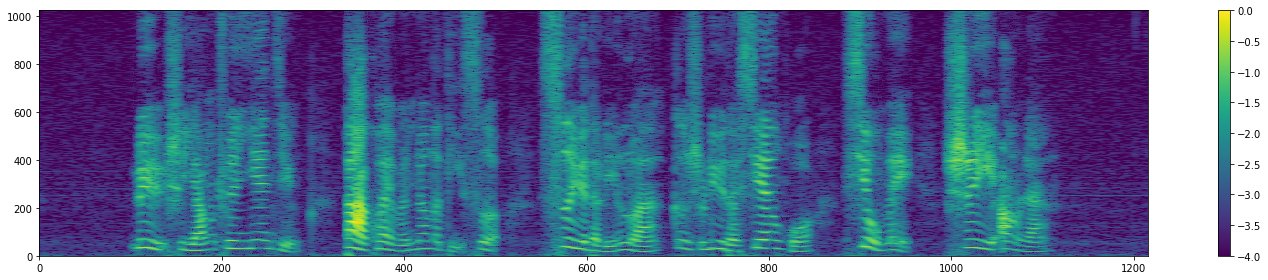

In [19]:
drawer_utils.plot_colorbar(np.transpose(spectrogram_wave))

#### 作用
* 将时域帧特性转换为频域帧特性
* 是很多频域特征的前提

#### 问题
* 无

#### 发现
* 特征从时域进行了扩展，将时域变量分解成多维频域变量

#### 个人理解
* 扩展了特征的大小

### 倒谱特征——MFCC

In [20]:
import feature_extraction.mfcc as mfcc
# For mels
n_mel_freq_components = 32 # number of mel frequency channels
shorten_factor = 10 # how much should we compress the x-axis (time)
start_freq = 300 # Hz # What frequency to start sampling our melS from 
end_freq = 8000 # Hz # What frequency to stop sampling our melS from 

In [21]:
# Generate the mel filters
mel_filter, mel_inversion_filter = mfcc.create_mel_filter(fft_size = fft_size,
                                                        n_freq_components = n_mel_freq_components,
                                                        start_freq = start_freq,
                                                        end_freq = end_freq)

e:\anaconda3\envs\mypython\lib\site-packages\scipy\ndimage\interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


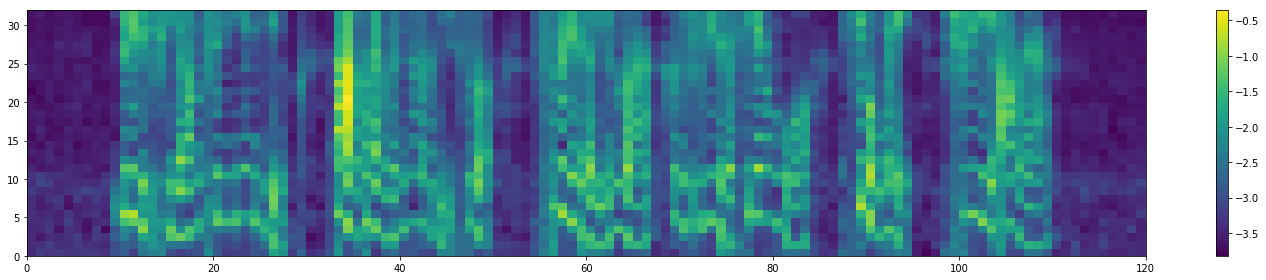

In [22]:
mel_spec = mfcc.make_mel(
    spectrogram_wave, 
    mel_filter, 
    shorten_factor = shorten_factor
)
drawer_utils.plot_colorbar(mel_spec.astype("float"))

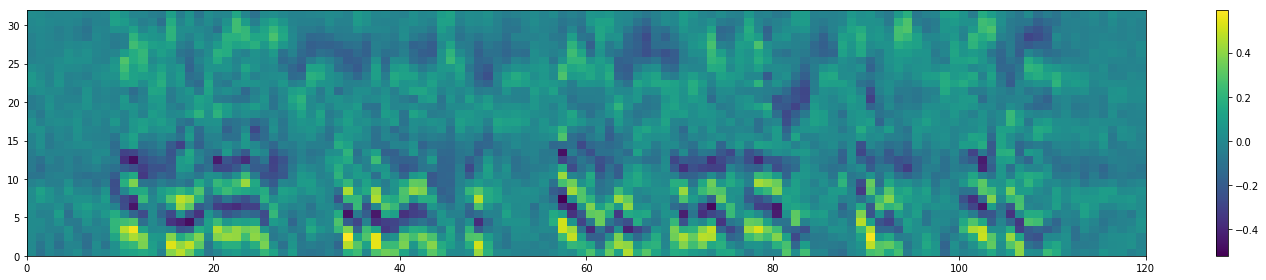

In [23]:
# mel变化差值
drawer_utils.plot_colorbar(mfcc.get_delta_mfcc(mel_spec,2))

#### 作用
* 模拟人耳对不同频率的声音不同的感知能力
* 1000HZ以下感知能力和频率呈线性关系
* 1000HZ以上呈对数关系

#### 问题
* 无

#### 发现
* 通过修改mel滤波器的个数可以控制声谱图的纵向“分辨率”
* 对低频具有一定的放大作用，高频有一定的压缩作用（类似于“归一化”）

#### 个人理解
* 与声谱图相比，降维、滤波、映射成更符合听觉感知的频谱图

### PLP

In [24]:
import feature_extraction.plp as plp

e:\anaconda3\envs\mypython\lib\importlib\_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
e:\anaconda3\envs\mypython\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


(979, 13)
(979,)
None
None


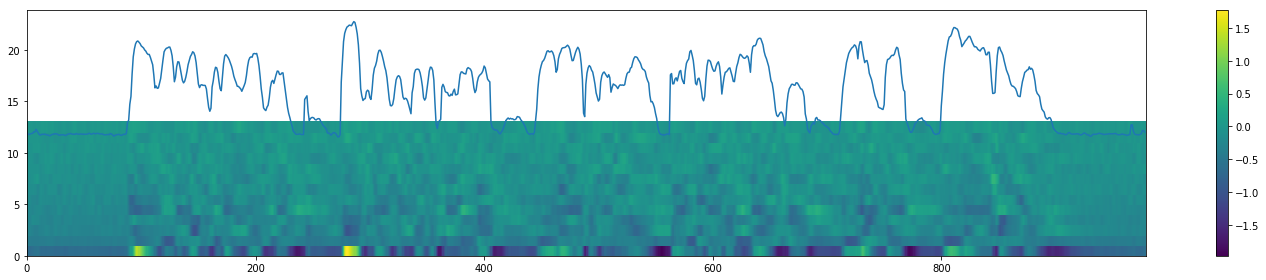

In [25]:
plp_ = plp.get_plp(audio,sampling_freq)
for i in range(len(plp_)):
    if plp_[i] is None:
        print("None")
    else:
        print(plp_[i].shape)
drawer_utils.plot_colormesh(np.transpose(plp_[0]))
drawer_utils.plot_array(plp_[1])

(979, 13)
(979,)
None
None


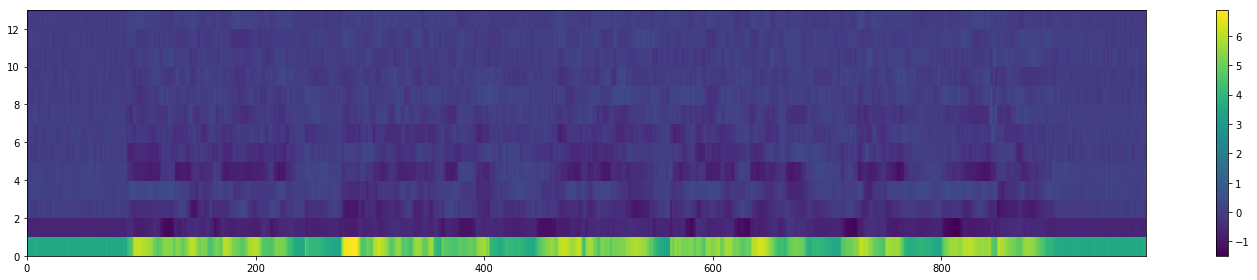

In [26]:
plp_ = plp.get_plp(audio,sampling_freq,rasta=False)
for i in range(len(plp_)):
    if plp_[i] is None:
        print("None")
    else:
        print(plp_[i].shape)
drawer_utils.plot_colormesh(np.transpose(plp_[0]))

#### 作用
* PLP在LPC的基础上加上了Bark域滤波，让LPC更适用于人耳的听觉习惯
* RASTA是在PLP的基础上加上RASTA滤波器，让模型对4Hz左右频率更敏感，更符合我们的正常说话的感觉

#### 问题
* 无

#### 发现
* 单纯的PLP特征过于凸显，两极分化严重
* 加入RASTA对提高低频作用，降低高频作用，看起来更合理。

#### 个人理解
* 加入RASTA更符合人的听觉系统，归一化的同时还滤除掉人耳不敏感的地方，加强了敏感的地方。

### Hilbert-Huang Transform

In [27]:
imfs , ht = preatreatment.hht(audio)
print(imfs.shape,ht.shape)

Mode 1, Iteration 600
3 minima > 0; 41873 maxima < 0.
Mode 1, Iteration 800
1 minima > 0; 42135 maxima < 0.
Mode 1, Iteration 1000
1 minima > 0; 42309 maxima < 0.
Mode 2, Iteration 1200
5 minima > 0; 25275 maxima < 0.
Mode 2, Iteration 1400
2 minima > 0; 25620 maxima < 0.
Mode 2, Iteration 1600
1 minima > 0; 25802 maxima < 0.
Mode 2, Iteration 1800
1 minima > 0; 25894 maxima < 0.


e:\anaconda3\envs\mypython\lib\site-packages\pyhht\emd.py:368: UserWarning: Emd:warning, Forced stop of sifting - Maximum iteration limit reached.
  "Maximum iteration limit reached.")


(4, 157000) (4, 157000)


### 共振峰

In [28]:
import feature_extraction.formant as formant

In [29]:
formant_ = formant.get_formant(wave_file)

In [30]:
print(formant_.shape)

(5, 1563)


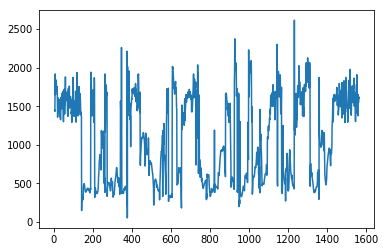

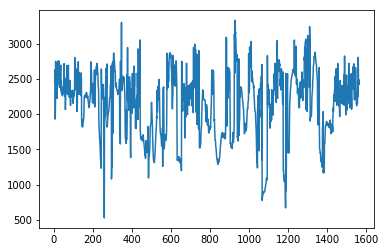

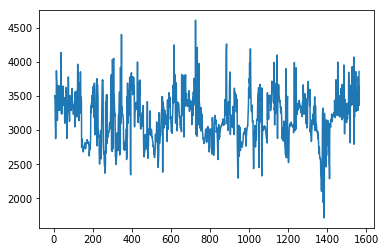

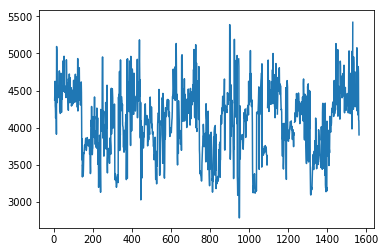

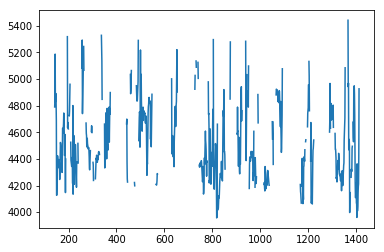

In [31]:
for row in formant_:
    drawer_utils.plot_array(row)

#### 作用
* 描述人类声道中的共振情形，不同的共振峰代表着不同的作用。
* 基频代表声带振动，共振峰代表声道振动

#### 问题
* 

#### 发现
* 从分布来讲F1的分布方差较大，后面的差异性变小
* F5开始出现“空缺”的现象（值为0），表明往后分析价值较低，频域分解有限

#### 个人理解
* 差异性越大越有代表性。

### Fbank

In [32]:
import feature_extraction.fbank as fbank

In [33]:
fbank_ = fbank.calcFbank(hanning_frames,sample_rate=sampling_freq)

In [34]:
print(fbank_.shape)

(613, 26)


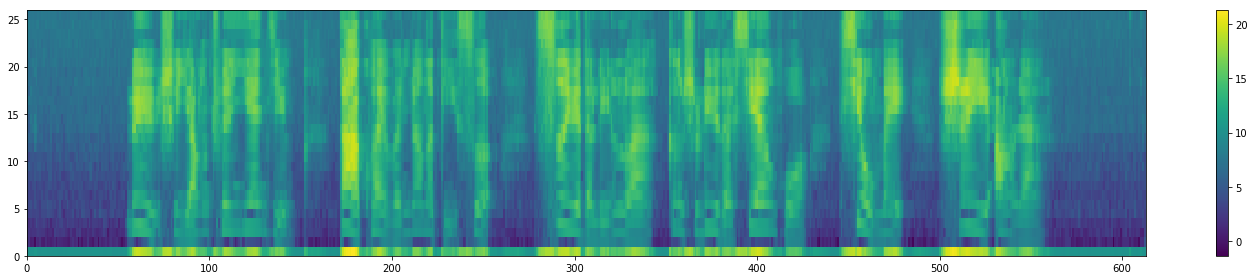

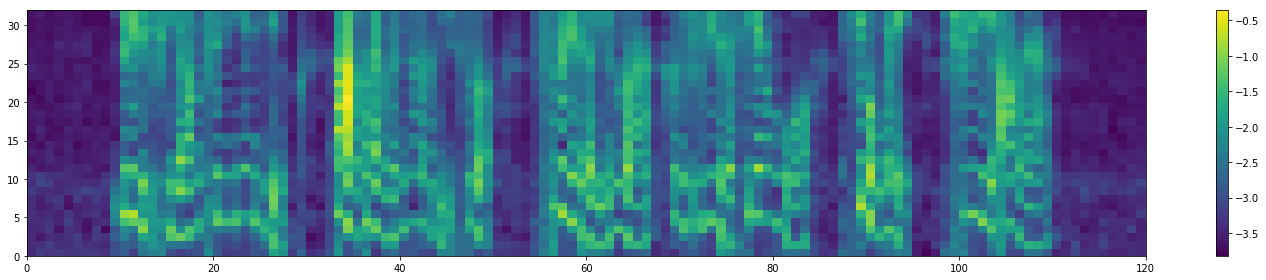

In [35]:
drawer_utils.plot_colorbar(np.transpose(fbank_))
drawer_utils.plot_colorbar(mel_spec.astype("float"))

#### 作用
* Fbank提取更多的是希望符合声音信号的本质，拟合人耳接受的特性

#### 问题
 

#### 发现
* 与MFCC（下图）相比，明显相关性较强，颜色偏亮表示，值都偏大，包括“空白语音”部分，颜色也是从下往上渐变。


#### 个人理解
* MFCC不一定是最优选择，因为神经网络对高度相关的信息不敏感，而且DCT变换是线性的，会丢失语音信号中原本的一些非线性成分。


### Log Fbank

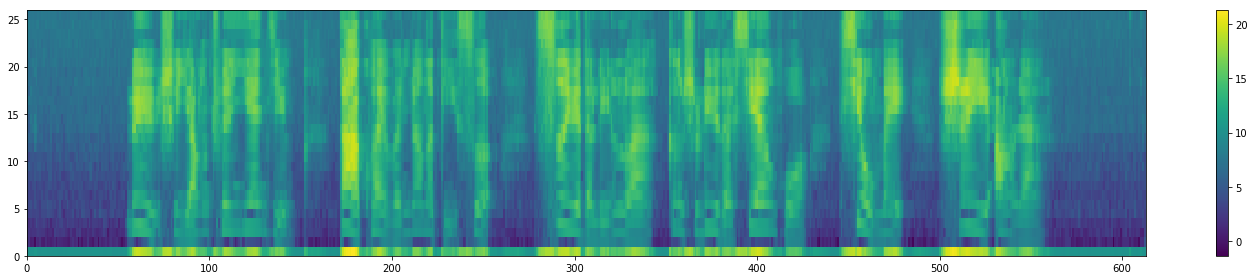

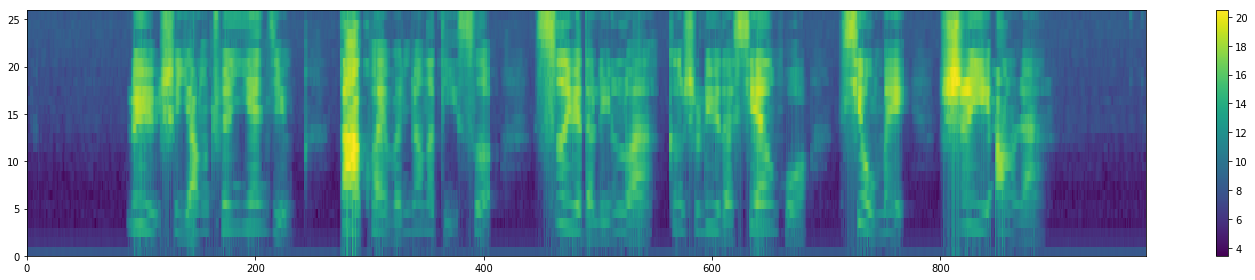

In [36]:
drawer_utils.plot_colorbar(np.transpose(fbank_))
drawer_utils.plot_colorbar(np.transpose(fbank.get_log_fbank(audio,sampling_freq)))

#### 作用
* Fbank加了个log

#### 问题


#### 发现
* 压缩，并降低了高频能量


#### 个人理解
* 减弱相关性


In [37]:
from feature_extraction.spectral_subband_centroids import get_ssc

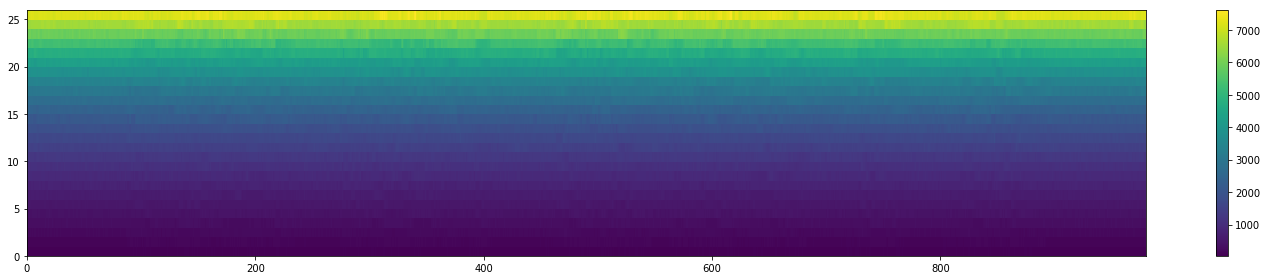

In [38]:
drawer_utils.plot_colorbar(np.transpose(get_ssc(audio,sampling_freq)))

### gammatonegram & GFCC

In [55]:
from feature_extraction.gammatone_gram import gammatonegram

In [70]:
sxx,center_freq = gammatonegram(
    audio,sr=sampling_freq,fmin=20,fmax=int(sampling_freq/2)
)

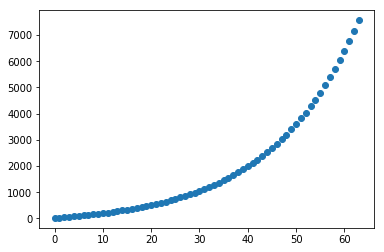

In [71]:
drawer_utils.scatter_array(center_freq)

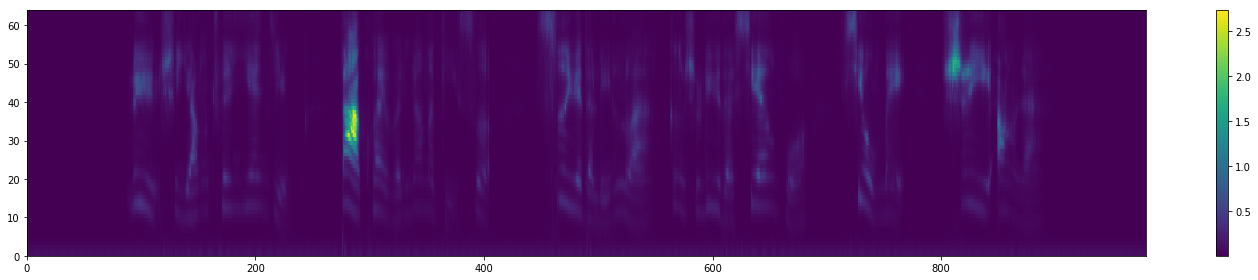

In [72]:
drawer_utils.plot_colorbar(sxx)

In [73]:
from feature_extraction.gfcc import get_gfcc
gfcc , center_freq = get_gfcc(audio,sampling_freq)
print(gfcc.shape,center_freq.shape)

(64, 979) (64,)


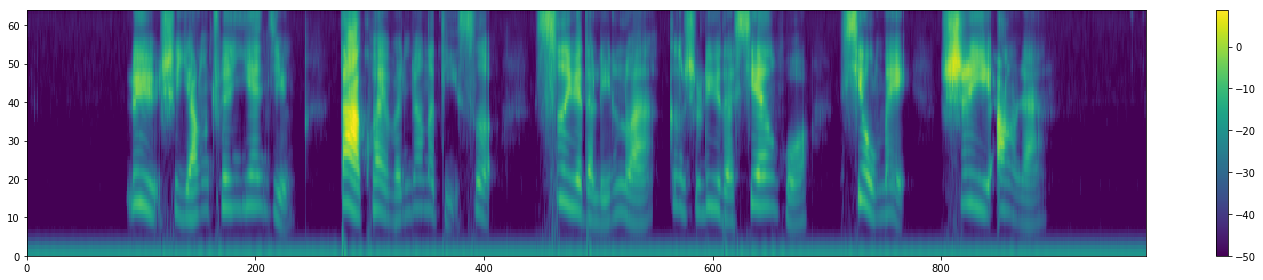

In [74]:
drawer_utils.plot_colorbar(gfcc)